# 2)

## a)

- **Regressifier**: Abstrakte Klasse als Gerüst für unterschiedliche Regressions-Algorithmen, **DataScaler**: Klasse zur Standardisierung von Daten-Vektoren (wird für einige Regressions-Algorithmen benötigt), **LSRRegressifier**: Implementierung des linearen least squares Regressions-Verfahrens mit Regularisierung, **KNNRegressifier**: Implementierung einer fast KNN-Regression mit KD-Trees
- Die abstrakte Methode **fit** dient der späteren Umsetzung des Lern-Algorithmus basierend auf den Daten-Vektoren X und den zugehörigen Labels T, die abstrakte Methode **predict** dient der späteren Umsetzung der "Vorhersage" des Regressions-Modells (Prognose von Zielvektor basierend auf Eingangsvektor x), die Methode **crossvalidate** dient der Implementierung einer S-fachen Cross-Validierung der Datenmenge X und der zugehörigen Labels T.
- Bei der **Klassifikations-Crossvalidate** wurden einfach Häufigkeiten gezählt (Klassifikation richtig vs. falsch) und daraus Wahrscheinlichkeiten berechnet, bei der **Regressions-Crossvalidate** wird hingegen geschaut wie weit (Abstand) das Modell daneben je Datenpunkt daneben liegt und auf Basis dieser Distanz (absolut vs. relativ, Dimensionen: Durchschnitt, Standard-Abweichung, max/min-Abweichung) die Güte des Regeressions-Modells bewertet.

## b)

- Die Funktion **berechnet Polynome vom Grad deg für eine übergebene Liste x**. Besteht die Liste x aus nur einem Wert berechnet die Funktion also x^0 x^1 ... x^deg. Besteht die **Liste aus mehreren Werten** (z.b. x und y), so berechnet sie alle Kombinationen von x * y, d.h. z.B. x^0 * y^0, x^1 * y^0, ... x^deg * y^0, allerdings **nur bis zum Polynomgrad deg=3 (x und y zusammen)**
- phi_polynomial([3],5) liefert [1,3,9,27,81,243]
- phi_polynomial([3,5],2) liefert [1,3,5,9,15,25]
- phi_polynomial([x1,x2],2) liefert allgemein [x1^0 * x2^0, x1^1 * x2^0, x1^0 * x2^1, x1^2 * x2^0, x1^1 * x2^1, x1^0 * x2^2]
- Man braucht die Funktion in der Regression um einen Datenvektor x in einen Merkmalsvektor phi mit polynomiellen Basisfunktionen umzurechnen. Die Merkmalsvektoren braucht man wiederum für die Designmatrix mit deren Hilfe man dann z.B. die optimalen Gewichte mittels Least Squares Regression ermitteln kann.
- Erweiterung auf Grad 5 s.u.

## c) 

- **LSRRegressifier** = Least Squares Regression mit Regularisierung
- **lambda** dient der Gewichtung der Regularisierung, **phi** definiert die Basis-Funktionen der linearen Regression (Standard: lineares Polynom vom Grad 1), mit **flagSTD** können die Daten X,T standardisiert werden auf Mittelwert 0 und Standardabweichung 1, **eps** dient der Definition des maximal akzeptierten Restwertes für numerisch gut konditionierte Probleme = verbleibende Ungenauigkeit beim Lösen der Optimierung
- Die Klasse **DataScaler** dient dazu, die Daten zu standardisieren (und nach der Regression wieder zu ent-standardisieren). Die Standardisierung erfolgt in der Methode **scale**, die Ent-Standardisierung in der Methode **unscale**. Die Standardisierung funktioniert wie folgt: Subtrahiere den Mittelwert von jeder Komponente und teile durch die Standartabweichung. Diese Methoden werden dann beim Trainieren (Methode **fit**) und bei der Vorhersage (Methode **predict**) angewendet um numerische Instabilitäten zu vermeiden (wenn STD-flag gesetzt). Wenn man die Daten nicht standardisiert, kann es je nach Problemstellung zu fehlerhaften/unbrauchbaren Ergebnissen kommen. Mit den Variablen **Z** und **maxZ** kann man für das gegebene Regressionsproblem dann prüfen wie fehlerhaft/ungenau die Berechnung ist. Wenn das Problem gut konditioniert ist, sollte die Matrix-Invertierung Z = 0 ergeben und damit auch der maximale Wert maxZ in Z = 0 sein und liegt dann unterhalb des maximal akzeptierten Restwertes. Wenn das Problem weniger gut konditioniert ist, kann der maximale Wert maxZ größer sein als der definierte maximal akzeptierte Restwert (eps) und man kann die Ergebnisse der Regression dann nicht verwenden.

## d) 

- Die Klasse **KNNRegressifier** basiert zunächst auf der K-nearest-neighbor-Suche (vgl. Versuch 1) und nutzt dann entweder die LeastSquares-Regression auf den gefundenen K-nearest-neighbors oder aber einfach den Durchschnitt der K-nearest-neighbor für die Prädiktion y(x). Die Daten X,T werden zunächst mit der Methode **fit** gespeichert (=trainiert). Anschließend kann man für einen neuen Vektor x mit **predict** den zugehörigen Wert y(x) vorhersagen. Dies erfolgt dann entweder auf Basis des Durchschnitts-t-Wertes der k-nearest-neighbor oder aber auf einer least-squares Regression auf den k-nearest neighbor.
- Der Parameter **K** gibt dabei an wieviele nächste Nachbarn berücksichtigt werden sollen, der Parameter **flagKLinReg** gibt an, ob die Prädiktion über eine LeastSquares-Regression auf den K-nearest-neighbors erfolgen soll oder ob einfach der Durchschnitt der K-nearest-neighbor als Prognose-Wert y(x) gewählt wird (flag=0 dann Durchschnitt, flag>0 least squares regression)

## e) 

Modultest:
1. 100 Daten-Punkte (X,T) erzeugen (wahre Funktion y=4+2x zzgl. Noise)
2. Basisfunktion definieren (lineares Polynom vom Grad 2, d.h. 1, x, x*x)
3. LSR berechnen (Gewichte) und dann auf einen Test-Vektor x=3.1415 anwenden
4. Kreuzvalidierung für LSR durchführen
5. KNN-Regression berechnen (mit K=5 und der Durchschnittsmethode (s.o.)) und auf Test-Vektor anwenden
6. Kreuzvalidierung für KNN-Regression durchführen

... Fortsetzung Aufgabe 2e) unten

In [2]:
#!/usr/bin/env python
# V2A2_Regression.py
# Programmgeruest zu Versuch 2, Aufgabe 2

import numpy as np
import scipy.spatial
from random import randint

# ----------------------------------------------------------------------------------------- 
# base class for regressifiers
# ----------------------------------------------------------------------------------------- 
class Regressifier:
    """
    Abstract base class for regressifiers
    Inherit from this class to implement a concrete regression algorithm
    """

    def fit(self,X,T):        # train/compute regression with lists of feature vectors X and class labels T
        """
        Train regressifier by training data X, T, should be overwritten by any derived class
        :param X: Data matrix of size NxD, contains in each row a data vector of size D
        :param T: Target vector matrix of size NxK, contains in each row a target vector of size K
        :returns: -
        """
        pass

    def predict(self,x):      # predict a target vector given the data vector x 
        """
        Implementation of the regression algorithm; should be overwritten by any derived class 
        :param x: test data vector of size D
        :returns: predicted target vector
        """
        return None           

    def crossvalidate(self,S,X,T,dist=lambda t: np.linalg.norm(t)):  # do a S-fold cross validation 
        """
        Do a S-fold cross validation
        :param S: Number of parts the data set is divided into
        :param X: Data matrix (one data vector per row)
        :param T: Matrix of target vectors; T[n] is target vector of X[n]
        :param dist: a fuction dist(t) returning the length of vector t (default=Euklidean)
        :returns (E_dist,sd_dist,E_min,E_max) : mean, standard deviation, minimum, and maximum of absolute error 
        :returns (Erel_dist,sdrel_dist,Erel_min,Erel_max) : mean, standard deviation, minimum, and maximum of relative error 
        """
        X,T=np.array(X),np.array(T)                         # ensure array type
        N=len(X)                                            # N=number of data vectors
        perm = np.random.permutation(N)                     # do a random permutation of X and T...
        X1,T1=[X[i] for i in perm], [T[i] for i in perm]    # ... to get random partitions of the data set
        idxS = [range(i*N//S,(i+1)*N//S) for i in range(S)] # divide data set into S parts:
        E_dist,E_dist2,E_max,E_min=0,0,-1,-1                # initialize first two moments of (absolute) regression error as well as max/min error 
        Erel_dist,Erel_dist2,Erel_max,Erel_min=0,0,-1,-1    # initialize first two moments of relative regression error as well as max/min error 
        for idxTest in idxS:                                # loop over all possible test data sets
            # (i) generate training and testing data sets and train classifier        
            idxLearn = [i for i in range(N) if i not in idxTest]                      # remaining indices (not in idxTest) are learning data
            if(S<=1): idxLearn=idxTest                                                # if S==1 use entire data set for learning and testing
            X_learn, T_learn = np.array([X1[i] for i in idxLearn]), np.array([T1[i] for i in idxLearn]) # learn data 
            X_test , T_test  = np.array([X1[i] for i in idxTest ]), np.array([T1[i] for i in idxTest ]) # test data 
            self.fit(X_learn,T_learn)                       # train regressifier
            # (ii) test regressifier
            for i in range(len(X_test)):  # loop over all data vectors to be tested
                # (ii.a) regress for i-th test vector
                xn_test = X_test[i].T                           # data vector for testing
                t_test = self.predict(xn_test)                  # predict target value for given test vector 
                # (ii.b) check for regression errors
                t_true = T_test[i].T                            # true target value
                d=dist(t_test-t_true)                           # (Euklidean) distance between t_test and t_true 
                dttrue=dist(t_true)                             # length of t_true
                E_dist  = E_dist+d                              # sum up distances (for first moment)
                E_dist2 = E_dist2+d*d                           # sum up squared distances (for second moment)
                if(E_max<0)or(d>E_max): E_max=d                 # collect maximal error
                if(E_min<0)or(d<E_min): E_min=d                 # collect minimal error
                drel=d/dttrue
                Erel_dist  = Erel_dist+drel                     # sum up relative distances (for first moment)
                Erel_dist2 = Erel_dist2+(drel*drel)             # sum up squared relative distances (for second moment)
                if(Erel_max<0)or(drel>Erel_max): Erel_max=drel  # collect maximal relative error
                if(Erel_min<0)or(drel<Erel_min): Erel_min=drel  # collect minimal relative error
        E_dist      = E_dist/float(N)                           # estimate of first moment (expected error)
        E_dist2     = E_dist2/float(N)                          # estimate of second moment (expected squared error)
        Var_dist    = E_dist2-E_dist*E_dist                     # variance of error
        sd_dist     = np.sqrt(Var_dist)                         # standard deviation of error
        Erel_dist   = Erel_dist/float(N)                        # estimate of first moment (expected error)
        Erel_dist2  = Erel_dist2/float(N)                       # estimate of second moment (expected squared error)
        Varrel_dist = Erel_dist2-Erel_dist*Erel_dist            # variance of error
        sdrel_dist  = np.sqrt(Varrel_dist)                      # standard deviation of error
        return (E_dist,sd_dist,E_min,E_max), (Erel_dist,sdrel_dist,Erel_min,Erel_max) # return mean, standard deviation, minimum, 
                                                                # and maximum error (for absolute and relative distances)  


# -------------------------------------------------------------------------------------------- 
# DataScaler: scale data to standardize data distribution (for mean=0, standard deviation =1)  
# -------------------------------------------------------------------------------------------- 
class DataScaler: 
    """
    Class for standardizing data vectors 
    Some regression methods require standardizing of data before training to avoid numerical instabilities!!
    """

    def __init__(self,X):               # X is data matrix, where rows are data vectors
        """
        Constructor: Set parameters (mean, std,...) to standardize data matrix X
        :param X: Data matrix of size NxD the standardization parameters (mean, std, ...) should be computed for 
        :returns: object of class DataScaler
        """
        self.meanX = np.mean(X,0)       # mean values for each feature column
        self.stdX  = np.std(X,0)        # standard deviation for each feature column 
        if isinstance(self.stdX,(list,tuple,np.ndarray)): 
            self.stdX[self.stdX==0]=1.0 # do not scale data with zero std (that is, constant features)
        else:
            if(self.stdX==0): self.stdX=1.0   # in case stdX is a scalar
        self.stdXinv = 1.0/self.stdX    # inverse standard deviation


    def scale(self,x):                  # scales data vector x to mean=0 and std=1
        """
        scale data vector (or data matrix) x to mean=0 and s.d.=1 
        :param x: data vector or data matrix  
        :returns: scaled (standardized) data vector or data matrix 
        """
        return np.multiply(x-self.meanX,self.stdXinv)

    def unscale(self,x):                # unscale data vector x to original distribution
        """
        unscale data vector (or data matrix) x to original data ranges  
        :param x: standardized data vector or data matrix  
        :returns: unscaled data vector or data matrix 
        """
        return np.multiply(x,self.stdX)+self.meanX

    def printState(self):
        """
        print standardization parameters (mean value, standard deviation (std), and inverse of std)  
        """
        print("mean=",self.meanX, " std=",self.stdX, " std_inv=",self.stdXinv)


# ----------------------------------------------------------------------------------------- 
# function to compute polynomial basis functions 
# ----------------------------------------------------------------------------------------- 
def phi_polynomial(x,deg=1):           # x should be list or np.array or 1xD matrix; returns an 1xM matrix 
    """
    polynomial basis function vector; may be used to transform a data vector x into a feature vector phi(x) having polynomial basis function components
    :param x: data vector to be transformed into a feature vector
    :param deg: degree of polynomial
    :returns phi: feature vector 
    Example: phi_polynomial(x,3) returns for one-dimensional x the vector [1, x, x*x, x*x*x]
    """
    x=np.array(np.mat(x))[0]           # ensure that x is a 1D array (first row of x)
    D=len(x)
    assert (D==1) or ((D>1) and (deg<=5)), "phi_polynomial(x,deg) not implemented for D="+str(D)+" and deg="+str(deg)    # MODIFY CODE HERE FOR deg>3 !!!!
    if(D==1):
        phi = np.array([x[0]**i for i in range(deg+1)])
    else:
        phi = np.array([])
        if(deg>=0):
            phi = np.concatenate((phi,[1]))      # include degree 0 terms
            if(deg>=1): 
                phi = np.concatenate((phi,x))    # includes degree 1 terms
                if(deg>=2):
                    for i in range(D):
                        phi = np.concatenate(( phi, [x[i]*x[j] for j in range(i+1)] ))    # include degree 2 terms
                    if(deg>=3):
                        for i in range(D):
                            for j in range(i+1):
                                phi = np.concatenate(( phi, [x[i]*x[j]*x[k] for k in range(j+1)] ))   # include degree 3 terms
                        if(deg>=4):
                            for i in range(D):
                                for j in range(i+1):
                                    for k in range(j+1):
                                        phi = np.concatenate((phi, [x[i]*x[j]*x[k]*x[l] for l in range(k+1)])) #include degree 4 terms
                            if(deg>=5):
                                for i in range(D):
                                    for j in range(i+1):
                                        for k in range(j+1):
                                            for l in range(k+1):
                                                phi = np.concatenate((phi, [x[i]*x[j]*x[k]*x[l]*x[m] for m in range(l+1)])) #include degree 5 terms

    return phi.T  # return basis function vector (=feature vector corresponding to data vector x)


# -----------------------------------------------------------------------------------------
# Least Squares (ML) linear regression with sum of squares Regularization,
# -----------------------------------------------------------------------------------------
class LSRRegressifier(Regressifier):
    """
    Class for Least Squares (or Maximum Likelihood) Linear Regressifier with sum of squares regularization 
    """

    def __init__(self,lmbda=0,phi=lambda x: phi_polynomial(x,1),flagSTD=0,eps=1e-6):
        """
        Constructor of class LSRegressifier
        :param lmbda: Regularization coefficient lambda
        :param phi: Basis-functions used by the linear model (default linear polynomial)
        :param flagSTD: If >0 then standardize data X and target values T (to mean 0 and s.d. 1)
        :param eps: maximal residual value to tolerate (instead of zero) for numerically good conditioned problems
        :returns: -
        """
        self.lmbda=lmbda       # set regression parameter (default 0)
        self.phi=phi           # set basis functions used for linear regression (default: degree 1 polynomials)
        self.flagSTD=flagSTD;  # if flag >0 then data will be standardized, i.e., scaled for mean 0 and s.d. 1
        self.eps=eps;          # maximal residual value to tolerate (instead of zero) for numerically good conditioned problems


    def fit(self,X,T,lmbda=None,phi=None,flagSTD=None): # train/compute LS regression with data matrix X and target value matrix T
        """
        Train regressifier (see lecture manuscript, theorem 3.11, p33) 
        :param X: Data matrix of size NxD, contains in each row a data vector of size D
        :param T: Target vector matrix of size NxK, contains in each row a target vector of size K
        :param lmbda: Regularization coefficient lambda
        :param phi: Basis-functions used by the linear model (default linear polynomial)
        :param flagSTD: If >0 then standardize data X and target values T (to mean 0 and s.d. 1)
        :returns: flagOK: if >0 then all is ok, otherwise matrix inversion was bad conditioned (and results should not be trusted!!!) 
        """
        # (i) set parameters
        if lmbda==None: lmbda=self.lmbda       # reset regularization coefficient?
        if phi==None: phi=self.phi             # reset basis functions?
        if flagSTD==None: flagSTD=self.flagSTD # standardize data vectors?
        # (ii) scale data for mean=0 and s.d.=0 ?
        if flagSTD>0:                          # if yes, then...
            self.datascalerX=DataScaler(X)     # create datascaler for data matrix X
            self.datascalerT=DataScaler(T)     # create datascaler for target matrix T
            X=self.datascalerX.scale(X)        # scale all features (=columns) of data matrix X to mean=0 and s.d.=1
            T=self.datascalerT.scale(T)        # ditto for target matrix T
        # (iii) compute weight matrix and check numerical condition
        flagOK,maxZ=1,0;                       # if <1 then matrix inversion is numerically infeasible
        try:
            self.N,self.D = X.shape            # data matrix X has size N x D (N is number of data vectors, D is dimension of a vector)
            self.M = self.phi(self.D*[0]).size # get number of basis functions  
            #self.K = T.shape[1]                # DELTE dummy code (just required for dummy code in predict(.): number of output dimensions
            PHI = np.array([self.phi(X[i]).T for i in range(self.N)])            # REPLACE dummy code: compute design matrix
            PHIT_PHI_lmbdaI = np.dot(PHI.T,PHI)+lmbda*np.eye(self.M)             # REPLACE dummy code: compute PHI_T*PHI+lambda*I
            PHIT_PHI_lmbdaI_inv = np.linalg.inv(PHIT_PHI_lmbdaI)                 # REPLACE dummy code: compute inverse matrix (may be bad conditioned and fail)
            self.W_LSR = np.dot(np.dot(PHIT_PHI_lmbdaI_inv,PHI.T),T)             # REPLACE dummy code: compute regularized least squares weights 
            # (iv) check numerical condition
            Z=np.dot(PHIT_PHI_lmbdaI,PHIT_PHI_lmbdaI_inv)-np.eye(self.M)       # REPLACE dummy code: Compute Z:=PHIT_PHI_lmbdaI*PHIT_PHI_lmbdaI_inv-I which should become the zero matrix if good conditioned!
            maxZ = np.max(Z)                                                   # REPLACE dummy code: Compute maximum (absolute) componente of matrix Z (should be <eps for good conditioned problem)
            assert maxZ<=self.eps              # maxZ should be <eps for good conditioned problems (otherwise the result cannot be trusted!!!)
        except: 
            flagOK=0;
            print("EXCEPTION DUE TO BAD CONDITION:flagOK=", flagOK, " maxZ=", maxZ)
            raise
        return flagOK 

    def predict(self,x,flagSTD=None):      # predict a target value given data vector x 
        """
        predicts the target value y(x) for a test vector x
        :param x: test data vector of size D
        :param flagSTD: If >0 then standardize data X and target values T (to mean 0 and s.d. 1)
        :returns: predicted target vector y of size K
        """
        if flagSTD==None: flagSTD=self.flagSTD      # standardization?
        if flagSTD>0: x=self.datascalerX.scale(x)   # if yes, then scale x before computing the prediction!
        phi_of_x = self.phi(x)                      # compute feature vector phi_of_x for data vector x
        y=np.dot(self.W_LSR.T,phi_of_x)
        #y=np.zeros((1,self.K)).T                    # REPLACE dummy code:  compute prediction y for data vector x 
        if flagSTD>0: y=self.datascalerT.unscale(y) # scale prediction back to original range?
        return y                  # return prediction y for data vector x



# -----------------------------------------------------------------------------------------
# KNN regression 
# -----------------------------------------------------------------------------------------
class KNNRegressifier(Regressifier): 
    """
    Class for fast K-Nearest-Neighbor-Regression using KD-trees 
    """

    def __init__(self,K,flagKLinReg=0):
        """
        Constructor of class KNNRegressifier
        :param K: number of nearest neighbors that are used to compute prediction 
        :flagKLinReg: if >0 then the do a linear (least squares) regression on the the K nearest neighbors and their target values
                      otherwise just take the mean of the K nearest neighbors target vectors
        :returns: -
        """
        self.K = K                                 # K is number of nearest-neighbors used for majority decision
        self.X, self.T = [],[]                     # initially no data is stored
        self.flagKLinReg=flagKLinReg               # if flag is set then do a linear regression of the KNN (otherwise just return mean T of the KNN)

    def fit(self,X,T): # train/compute regression with lists of data vectors X and target values T
        """
        Train regressifier by stroing X and T and by creating a KD-Tree based on X   
        :param X: Data matrix of size NxD, contains in each row a data vector of size D
        :param T: Target vector matrix of size NxK, contains in each row a target vector of size K
        :returns: -
        """
        self.X, self.T = np.array(X),np.array(T)   # just store feature vectors X and corresponding class labels T
        self.N, self.D = self.X.shape              # store data number N and dimension D
        self.kdtree = scipy.spatial.KDTree(self.X) # do an indexing of the feature vectors

    def predict(self,x,K=None,flagKLinReg=None):   # predict a target value given data vector x 
        """
        predicts the target value y(x) for a test vector x
        :param x: test data vector of size D
        :param K: number of nearest neighbors that are used to compute prediction 
        :flagKLinReg: if >0 then the do a linear (least squares) regression on the the K nearest neighbors and their target values
                      otherwise just take the mean of the K nearest neighbors target vectors
        :returns: predicted target vector of size K
        """
        if(K==None): K=self.K                      # do a K-NN search...
        if(flagKLinReg==None): flagKLinReg=self.flagKLinReg # if flag >0 then do a regression on the K Nearest Neighbors to get the prediction
        nn = self.kdtree.query(x,K)                # get indexes of K nearest neighbors of x
        if K==1: idxNN=[nn[1]]                     # cast nearest neighbor indexes nn as a list idxNN
        else: idxNN=nn[1]
        t_out=0
        if(self.flagKLinReg==0):
            # just take mean value of KNNs
            t_out=np.mean([self.T[i] for i in idxNN])
        else:
            # do a linear regression of the KNNs
            lsr=LSRegressifier(lmbda=0.0001,phi=lambda x:phi_polynomial(x,1),flagSTD=1)
            lsr.fit(self.X[idxNN],self.T[idxNN])
            t_out=lsr.predict(x)
        return t_out


# *******************************************************
# __main___
# Module test
# *******************************************************

if __name__ == '__main__':
    print("\n-----------------------------------------")
    print("Example: 1D-linear regression problem")
    print("-----------------------------------------")
    # (i) generate data
    N=100
    w0,w1=4,2                 # parameters of line
    X=np.zeros((N,1))         # x data: allocate Nx1 matrix as numpy ndarray
    X[:,0]=np.arange(0,50.0,50.0/N)  # equidistant sampling of the interval [0,50)
    T=np.zeros((N,1))         # target values: allocate Nx1 matrix as numpy ndarray
    sd_noise = 1.0            # noise power (=standard deviation)
    T=T+w1*X+w0 + np.random.normal(0,sd_noise,T.shape)  # generate noisy target values on line y=w0+w1*x
    par_lambda = 0            # regularization parameter
    print("X=",X)
    print("T=",T)

    # (ii) define basis functions (phi should return list of basis functions; x should be a list)
    deg=2;                               # degree of polynomial
    phi=lambda x: phi_polynomial(x,2)    # define phi by polynomial basis-functions up to degree deg 
    print("phi(4)=", phi([4]))           # print basis function vector [1, x, x*x ...] for x=4
    print("phi([1,2])=", phi([1,2]))     # print basis function vector for two-dim. inputs (yields many output components) 

    # (iii) compute LSR regression
    print("\n-----------------------------------------")
    print("Do a Least-Squares-Regression")
    print("-----------------------------------------")
    lmbda=0;
    lsr = LSRRegressifier(lmbda,phi)
    lsr.fit(X,T)
    print("lsr.W_LSR=",lsr.W_LSR)        # weight vector (should be approximately [w0,w1]=[4,2])
    x=np.array([3.1415]).T
    print("prediction of x=",x,"is y=",lsr.predict(x))

    # do S-fold crossvalidation
    S=3
    err_abs,err_rel = lsr.crossvalidate(S,X,T)
    print("LSRRegression cross-validation: absolute errors (E,sd,min,max)=", err_abs, "  relative errors (E,sd,min,max)=", err_rel)

    # (iv) compute KNN-regression
    print("\n-----------------------------------------")
    print("Do a KNN-Regression")
    print("-----------------------------------------")
    K=5;
    knnr = KNNRegressifier(K)
    knnr.fit(X,T)
    print("prediction of x=",x,"is y=",knnr.predict(x))

    # do S-fold crossvalidation
    err_abs,err_rel = knnr.crossvalidate(S,X,T)
    print("KNNRegression cross-validation: absolute errors (E,sd,min,max)=", err_abs, "  relative errors (E,sd,min,max)=", err_rel)





-----------------------------------------
Example: 1D-linear regression problem
-----------------------------------------
X= [[ 0. ]
 [ 0.5]
 [ 1. ]
 [ 1.5]
 [ 2. ]
 [ 2.5]
 [ 3. ]
 [ 3.5]
 [ 4. ]
 [ 4.5]
 [ 5. ]
 [ 5.5]
 [ 6. ]
 [ 6.5]
 [ 7. ]
 [ 7.5]
 [ 8. ]
 [ 8.5]
 [ 9. ]
 [ 9.5]
 [10. ]
 [10.5]
 [11. ]
 [11.5]
 [12. ]
 [12.5]
 [13. ]
 [13.5]
 [14. ]
 [14.5]
 [15. ]
 [15.5]
 [16. ]
 [16.5]
 [17. ]
 [17.5]
 [18. ]
 [18.5]
 [19. ]
 [19.5]
 [20. ]
 [20.5]
 [21. ]
 [21.5]
 [22. ]
 [22.5]
 [23. ]
 [23.5]
 [24. ]
 [24.5]
 [25. ]
 [25.5]
 [26. ]
 [26.5]
 [27. ]
 [27.5]
 [28. ]
 [28.5]
 [29. ]
 [29.5]
 [30. ]
 [30.5]
 [31. ]
 [31.5]
 [32. ]
 [32.5]
 [33. ]
 [33.5]
 [34. ]
 [34.5]
 [35. ]
 [35.5]
 [36. ]
 [36.5]
 [37. ]
 [37.5]
 [38. ]
 [38.5]
 [39. ]
 [39.5]
 [40. ]
 [40.5]
 [41. ]
 [41.5]
 [42. ]
 [42.5]
 [43. ]
 [43.5]
 [44. ]
 [44.5]
 [45. ]
 [45.5]
 [46. ]
 [46.5]
 [47. ]
 [47.5]
 [48. ]
 [48.5]
 [49. ]
 [49.5]]
T= [[  1.79849963]
 [  4.10557112]
 [  7.01314228]
 [  6.3166319 ]
 [  6.

Gewichte LSR:
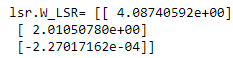

- Funktion: y = 4,0874 + 2,0105 * x - 0,0002 * x^2 
- Für N->unendlich sollte sich dann idealerweise die "wahre" Funktion y = 4 + 2 * x ergeben

Die 3-fache Kreuzvalidierung liefert den mittleren Erwartungswert, Standardabweichung, minimalen und maximalen Wert des Fehlers des Regressionsmodell (sowohl in absoluten Werten als auch in relativen Werten). In der vorgegebenen Konfiguration des Modultests, erzielt die LSR-Regression gegenüber der KNN-Regression bessere Ergebnisse (geringere Abweichung). Dies ist auch der Fall wenn die Parameter lambda und K verändert/optimiert werden.

In [16]:
print("\n-----------------------------------------")
print("Example: 1D-linear regression problem")
print("-----------------------------------------")
# (i) generate data
N=100
w0,w1=4,2                 # parameters of line
X=np.zeros((N,1))         # x data: allocate Nx1 matrix as numpy ndarray
X[:,0]=np.arange(0,50.0,50.0/N)  # equidistant sampling of the interval [0,50)
T=np.zeros((N,1))         # target values: allocate Nx1 matrix as numpy ndarray
sd_noise = 1.0            # noise power (=standard deviation)
T=T+w1*X+w0 + np.random.normal(0,sd_noise,T.shape)  # generate noisy target values on line y=w0+w1*x
par_lambda = 0            # regularization parameter
print("X=",X)
print("T=",T)

# (ii) define basis functions (phi should return list of basis functions; x should be a list)
deg=2;                               # degree of polynomial
phi=lambda x: phi_polynomial(x,2)    # define phi by polynomial basis-functions up to degree deg 
print("phi(4)=", phi([4]))           # print basis function vector [1, x, x*x ...] for x=4
print("phi([1,2])=", phi([1,2]))     # print basis function vector for two-dim. inputs (yields many output components) 

# (iii) compute LSR regression
print("\n-----------------------------------------")
print("Do a Least-Squares-Regression")
print("-----------------------------------------")
lmbda=0.1;
lsr = LSRRegressifier(lmbda,phi)
lsr.fit(X,T)
print("lsr.W_LSR=",lsr.W_LSR)        # weight vector (should be approximately [w0,w1]=[4,2])
x=np.array([3.1415]).T
print("prediction of x=",x,"is y=",lsr.predict(x))

# do S-fold crossvalidation
S=3
err_abs,err_rel = lsr.crossvalidate(S,X,T)
print("LSRRegression cross-validation: absolute errors (E,sd,min,max)=", err_abs, "  relative errors (E,sd,min,max)=", err_rel)

# (iv) compute KNN-regression
print("\n-----------------------------------------")
print("Do a KNN-Regression")
print("-----------------------------------------")
K=10;
knnr = KNNRegressifier(K)
knnr.fit(X,T)
print("prediction of x=",x,"is y=",knnr.predict(x))

# do S-fold crossvalidation
err_abs,err_rel = knnr.crossvalidate(S,X,T)
print("KNNRegression cross-validation: absolute errors (E,sd,min,max)=", err_abs, "  relative errors (E,sd,min,max)=", err_rel)



-----------------------------------------
Example: 1D-linear regression problem
-----------------------------------------
X= [[ 0. ]
 [ 0.5]
 [ 1. ]
 [ 1.5]
 [ 2. ]
 [ 2.5]
 [ 3. ]
 [ 3.5]
 [ 4. ]
 [ 4.5]
 [ 5. ]
 [ 5.5]
 [ 6. ]
 [ 6.5]
 [ 7. ]
 [ 7.5]
 [ 8. ]
 [ 8.5]
 [ 9. ]
 [ 9.5]
 [10. ]
 [10.5]
 [11. ]
 [11.5]
 [12. ]
 [12.5]
 [13. ]
 [13.5]
 [14. ]
 [14.5]
 [15. ]
 [15.5]
 [16. ]
 [16.5]
 [17. ]
 [17.5]
 [18. ]
 [18.5]
 [19. ]
 [19.5]
 [20. ]
 [20.5]
 [21. ]
 [21.5]
 [22. ]
 [22.5]
 [23. ]
 [23.5]
 [24. ]
 [24.5]
 [25. ]
 [25.5]
 [26. ]
 [26.5]
 [27. ]
 [27.5]
 [28. ]
 [28.5]
 [29. ]
 [29.5]
 [30. ]
 [30.5]
 [31. ]
 [31.5]
 [32. ]
 [32.5]
 [33. ]
 [33.5]
 [34. ]
 [34.5]
 [35. ]
 [35.5]
 [36. ]
 [36.5]
 [37. ]
 [37.5]
 [38. ]
 [38.5]
 [39. ]
 [39.5]
 [40. ]
 [40.5]
 [41. ]
 [41.5]
 [42. ]
 [42.5]
 [43. ]
 [43.5]
 [44. ]
 [44.5]
 [45. ]
 [45.5]
 [46. ]
 [46.5]
 [47. ]
 [47.5]
 [48. ]
 [48.5]
 [49. ]
 [49.5]]
T= [[  2.57830908]
 [  4.70280046]
 [  5.56844613]
 [  7.93888344]
 [  9.